In [2]:
import numpy as np
import pyPLUTO as pp
from astropy.io import ascii
import os
import sys
from ipywidgets import interactive, widgets,fixed
from IPython.display import Audio, display
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation,FFMpegWriter
from matplotlib import rc,rcParams
from scipy.integrate import quad
rc('text', usetex=True)
rcParams['figure.figsize'] = (15., 6.0)
rcParams['ytick.labelsize'],rcParams['xtick.labelsize'] = 17.,17.
rcParams['axes.labelsize']=19.
rcParams['legend.fontsize']=17.
rcParams['text.latex.preamble'] = ['\\usepackage{siunitx}']
import seaborn
seaborn.despine()
seaborn.set_style('white', {'axes.linewidth': 0.5, 'axes.edgecolor':'black'})
seaborn.despine(left=True)
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%autoreload 1

In [4]:
%aimport f

## Data from H2Cooling with Gravity

In [5]:
HCG=np.load('../Data/H2CoolingG512.npz')

Maximum Density: 9.75e-18 g/cm3 (5.84e+06 cu) at time 2.47 Myrs (index: 26)


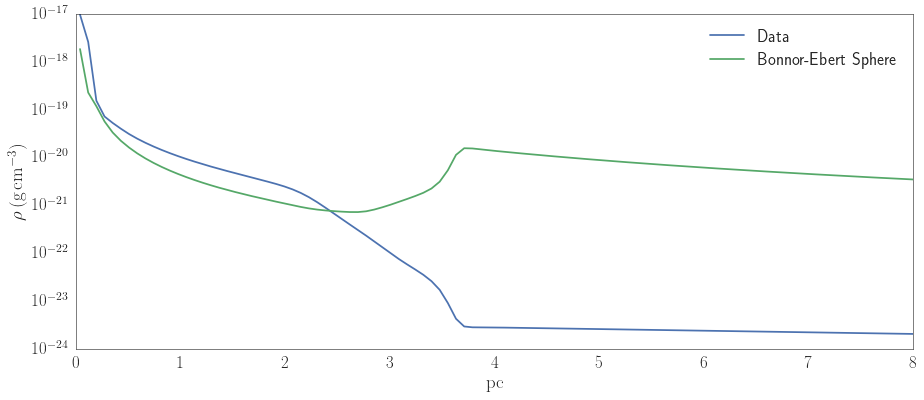

In [178]:
mid=256
print 'Maximum Density: {:.2e} g/cm3 ({:.2e} cu) at time {:.2f} Myrs (index: {})'.format(HCG['RHO'][mid,mid:,ind].max()*f.RHO0,HCG['RHO'][mid,mid,:].max(),HCG['T'][ind]/1e6,ind)
ind= HCG['RHO'][mid,mid,:].argmax()
xs=HCG['X'][mid:]#/10.
ys=HCG['RHO'][mid,mid:,ind]#*f.RHO0
ps=HCG['PRS'][mid,mid:,ind]
cs=np.sqrt((5./3)*ps*f.PRS0/(ys*f.RHO0))
xspc=xs*10.
xau=xscgs*206265.
yscgs=ys*f.RHO0
ybe=cs**2/(2.*np.pi*6.67e-8*(xspc*3.086e18)**2)
ax=plt.subplot(111)
ax.plot(xspc,yscgs,label='Data')
ax.plot(xspc,ybe,label='Bonnor-Ebert Sphere')
ax.set_yscale('log')
ax.set_ylabel('$ \\rho\, (\si{g.cm^{-3}})$')
ax.set_xlabel('$\si{pc}$')
ax.set_xlim(None,8)
plt.legend()

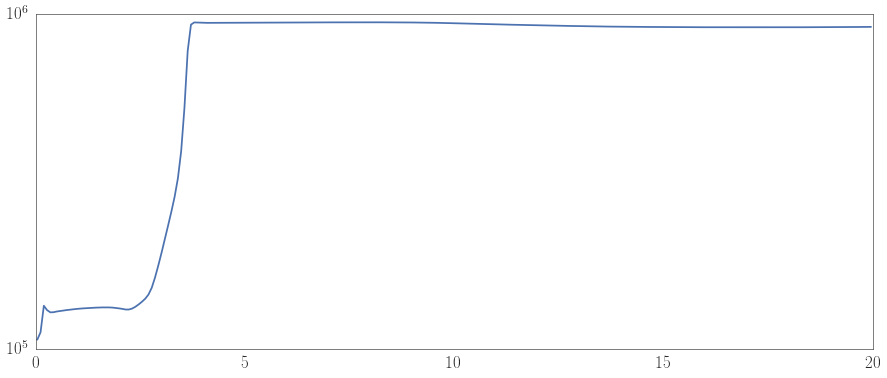

In [180]:
plt.plot(xspc,cs)
plt.yscale('log')

(0.0, 0.8)

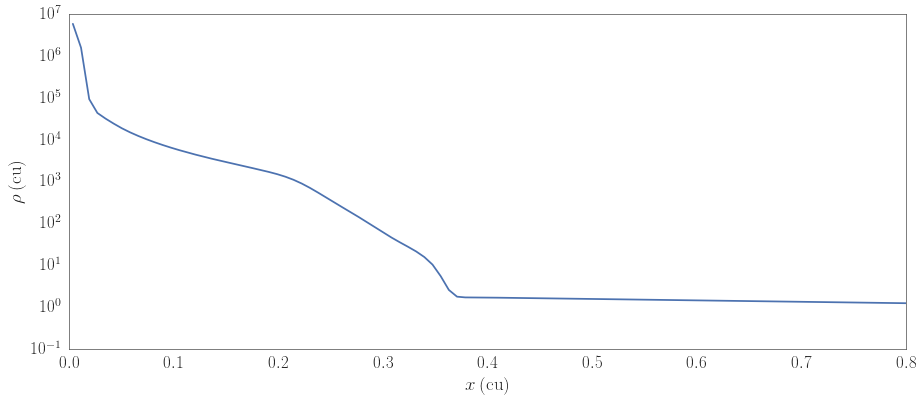

In [56]:
ax1=plt.subplot(111)
ax1.plot(xs,ys)
ax1.set_yscale('log')
ax1.set_ylabel('$ \\rho\, (\si{cu})$')
ax1.set_xlabel('$x \, (\si{cu}) $')
ax1.set_xlim(None,0.8)

NonLinear Fit: ln(p) = (-2.4+-1.04)*ln(x)+(2.8+-4.9)
NonLinear Fit: ln(p) = (-1.8+-0.03)*ln(x)+(4.6+-0.1)
NonLinear Fit: ln(p) = (-10.0+-0.31)*ln(x)+(-8.0+-0.4)
NonLinear Fit: ln(p) = (-2.9+-0.18)*ln(x)+(1.6+-0.4)


(0.0, 0.45)

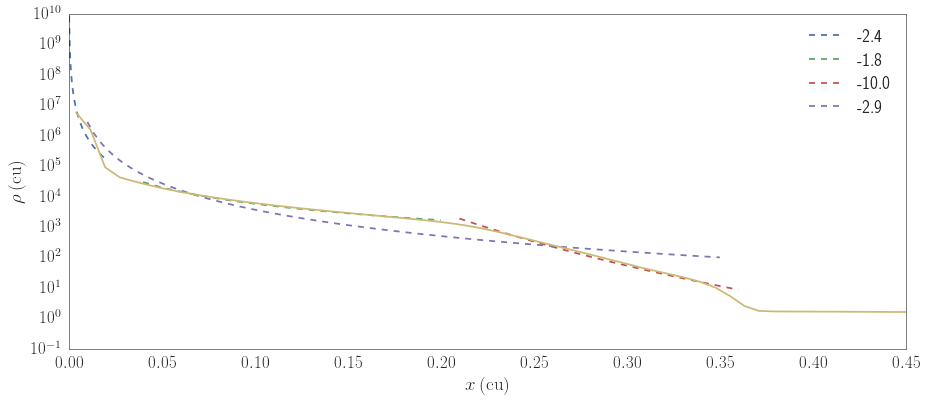

In [191]:
regions= [[0.0,0.02],[0.04,0.2],[0.21,0.36],[0.01,0.35]]
for region in regions:
    xmin,xmax=region[0],region[1]
    whr=np.logical_and(xs>xmin,xs<xmax)
    xsl=np.log(xs[whr])
    ysl=np.log(ys[whr])
    from scipy.optimize import curve_fit
    def ff(x,a,b,): return a*x+b 
    p,dp2=curve_fit(ff,xsl,ysl,[-2.1,100.])
    dp=np.sqrt(np.diag(dp2))
    print 'NonLinear Fit: ln(p) = ({:.1f}+-{:.2f})*ln(x)+({:.1f}+-{:.1f})'.format(p[0],dp[0],p[1],dp[1])
    xx=np.linspace(xmin,xmax,100)   
    plt.plot(xx,np.exp(p[1])*xx**(p[0]),'--',label='{:.1f}'.format(p[0]))
plt.plot(xs,ys)
plt.yscale('log')
plt.ylabel('$ \\rho\, (\si{cu})$')
plt.xlabel('$x\, (\si{cu})$')
plt.legend()
plt.xlim(None,0.45)

In [153]:
Cscu*f.V0

12247.448713915892

$$
\rho_{BE} (r)  = \frac{C_s^2}{4 \pi G r^2} =\frac{L_0^2 \rho _0 t_0}{t_0^2  L_0^2}
$$

(0.0, 10)

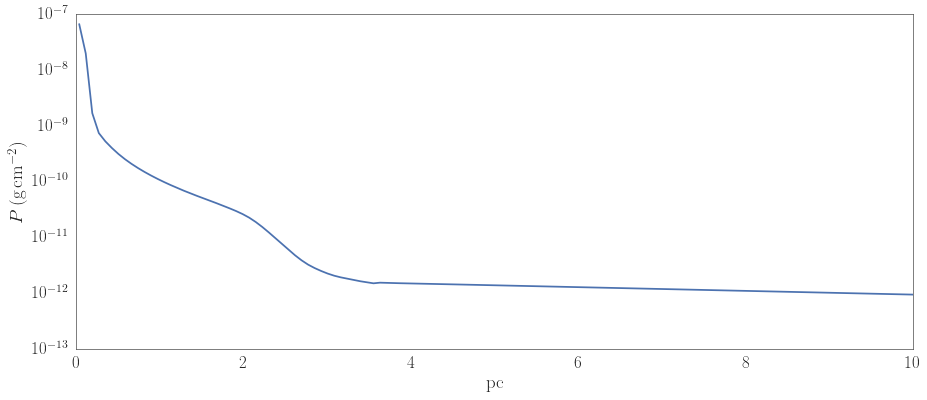

In [62]:
xs=HCG['X'][mid:]
ysP=HCG['PRS'][mid,mid:,ind]
xscgs=xs*10.
xau=xscgs*206265.
ysPcgs=ysP*f.PRS0
ax=plt.subplot(111)
ax.plot(xscgs,ysPcgs)
ax.set_yscale('log')
ax.set_ylabel('$ P\, (\si{g.cm^{-2}})$')
ax.set_xlabel('$\si{pc}$')
ax.set_xlim(None,10)

## Simulate Profile

In [95]:
Radius = 1.0
Density1 = 10.
P0=1e-8
T0=10891304347826.088
def rho(r,a=2.3,rho1=10.,R=1.,rc=0.002): return np.piecewise(r, [r < R , r >= R], [lambda r: rho1/(rc+r**a), 1.])
def mass(r,sm=False): 
    return 4.*np.pi*r**2 *rho(r)*24.73 if sm else 4.*np.pi*r**2 *rho(r)
#def massmo(r,a,rc): return mass(r,a=-2.3,rho0=1e5,rc=0.005,R=10.) *24.73 #(10pc)^3 * hydrogen_mass /cm^3 = 24.73 Mo

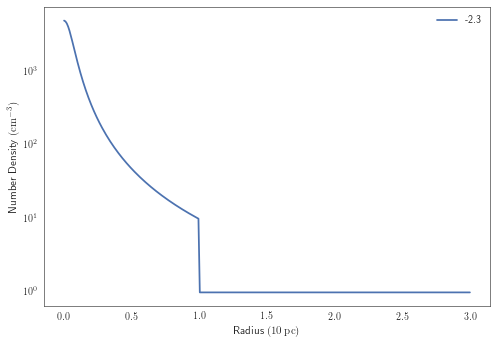

In [104]:
r=np.linspace(-2,3,500)
plt.ylabel('Number Density $(\si{cm^{-3}})$')
plt.xlabel('Radius $(\SI{10}{pc})$')
plt.yscale('log')
plt.plot(r,rho(r),label=-2.3)
plt.legend()

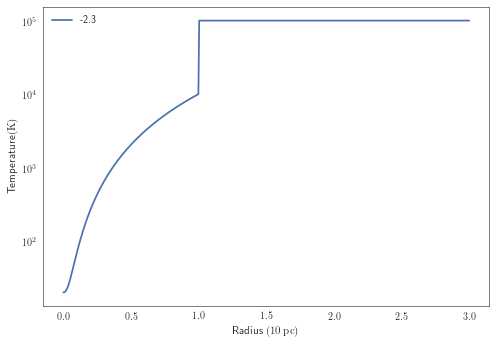

In [97]:
plt.ylabel('Temperature$(\si{K})$')
plt.xlabel('Radius $(\SI{10}{pc})$')
plt.yscale('log')
plt.plot(r,P0*T0/rho(r),label=-2.3)
plt.legend()

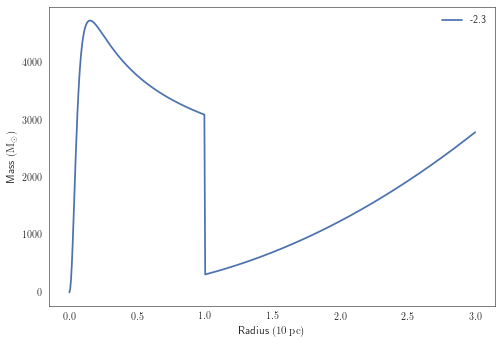

In [98]:
plt.plot(r,mass(r,sm=True),label=-2.3)
#plt.plot(r,4.*np.pi*r**2 *rho(r),label=-2.3)
plt.ylabel('Mass $(\si{M_\odot})$')
plt.xlabel('Radius $(\SI{10}{pc})$')
plt.legend()

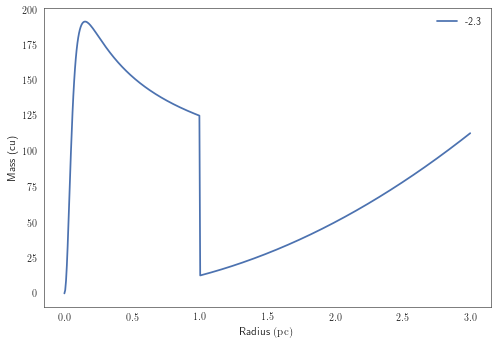

In [99]:
plt.plot(r,mass(r),label=-2.3)
plt.ylabel('Mass (cu)')
plt.xlabel('Radius $(\si{pc})$')
plt.legend()

In [100]:
TotalMass=quad(mass,0,1.,args=True)[0]
print u'Total Mass: {:.3e} M☉'.format(TotalMass)
TotalMass=quad(mass,0,1.)[0]
print u'Total Mass: {:e} cu'.format(TotalMass)

Total Mass: 3.660e+03 M☉
Total Mass: 1.479808e+02 cu


$$
4\pi \rho_0 \int _0 ^R \frac{R_c r^2}{R_c +r^2}dr =
4\pi \rho_0 Rc \Big( R-\sqrt{R_c} \arctan\big( \frac{R}{\sqrt{R_C}}\big) \Big)
$$

In [139]:
def integral(rho1,R):
    return 17.952*rho1*R**0.7
    #return 4.*np.pi*rho0*Rc*(R-np.sqrt(Rc)*np.arctan(R/np.sqrt(Rc)))

In [140]:
integral(10.,1.)

179.52